<a href="https://colab.research.google.com/github/EmmanueleVilla/quantum_computing/blob/main/Colab_22_Costo_e_Optimization_Loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit --quiet && pip install pylatexenc --quiet && pip install qiskit-aer --quiet && pip install qiskit[nature] --quiet && pip install pyscf --quiet

## Esempio di funzioni di costo

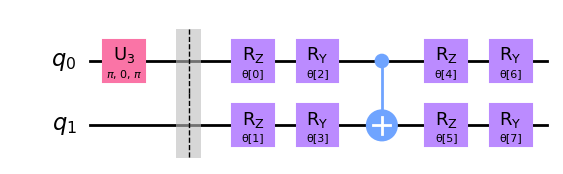

array([0.73277923])

In [11]:
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler, Estimator
from qiskit.quantum_info import SparsePauliOp
import numpy as np

# Funzione di costo
def cost_function_vqe(theta):

  # Osservabile
  observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])

  # Circuito di riferimento
  reference_circuit = QuantumCircuit(2)
  reference_circuit.x(0)
  reference_circuit.barrier()

  # Variational form N-Locale
  variational_form = TwoLocal(
      2,
      rotation_blocks=["rz", "ry"],
      entanglement_blocks="cx",
      entanglement="linear",
      reps=1,
  )

  # Ansatz
  ansatz = reference_circuit.compose(variational_form)

  # Mostra il circuito
  display(ansatz.decompose().draw("mpl"))


  # Usa Estimator per ottenere l'expected value dell'ansatz
  estimator = Estimator()
  job = estimator.run(ansatz, observable, theta)
  values = job.result().values

  return values

# Lista di parametri theta casuali
theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()

# Expected value
cost_function_vqe(theta_list)

In [4]:
!pip install qiskit-optimization

## Da funzione di costo a osservabile

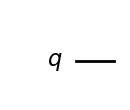

  >> Valore atteso: 1.00000


In [12]:
# Calcolo il valore atteso dello stato |0>

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Sampler, Estimator
from qiskit.circuit.library import IGate, ZGate
import numpy as np

# Creo lo stato |0>
original_circuit = QuantumCircuit(1)

# Creo l'osservabile
H = SparsePauliOp(["Z"], [1])

# Creo circuiti aggiuntivi per ogni porta della scomposizione dell'osservabile
aux_circuits = []
for pauli in H.paulis:
    aux_circ = original_circuit.copy()
    aux_circ.barrier()
    if str(pauli) == "X":
        aux_circ.h(0)
    else:
        aux_circ.i(0)
    aux_circ.measure_all()
    aux_circuits.append(aux_circ)

display(original_circuit.draw("mpl"))

# Sampler
sampler = Sampler()
job = sampler.run(aux_circuits)
probability_dists = job.result().quasi_dists

expvals = []
for dist, pauli in zip(probability_dists, H.paulis):
    val = 0
    if str(pauli) == "I":
        Lambda = IGate().to_matrix().real
    else:
        Lambda = ZGate().to_matrix().real
    val += Lambda[0][0] * dist.get(0, 0)
    val += Lambda[1][1] * dist.get(1, 0)
    expvals.append(val)

# Estimator
observables = [
    *H.paulis,
    H,
]

estimator = Estimator()
job = estimator.run([original_circuit] * len(observables), observables)
estimator_expvals = job.result().values

for (obs, expval) in zip(observables, estimator_expvals):
    if obs is H:
        print(f"  >> Valore atteso: {expval:.5f}")

## Il problema del taglio massimo

{(0, 1): Text(-0.4999999940375597, -0.5000000437113883, '1.0'),
 (0, 2): Text(0.0, 4.371138828673793e-08, '1.0'),
 (0, 3): Text(-0.500000168883119, 0.4999999562886117, '1.0'),
 (1, 2): Text(0.5000000059624403, -0.4999999125772234, '1.0'),
 (2, 3): Text(0.49999983111688096, 0.5000000874227766, '1.0')}

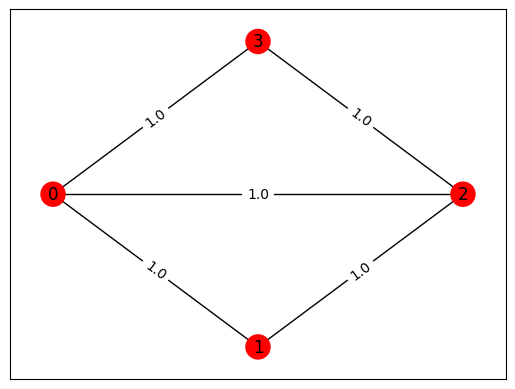

In [13]:
# Stampo il grafo del problema

import networkx as nx

n = 4
G = nx.Graph()
G.add_nodes_from(range(n))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_weighted_edges_from(edge_list)

colors = ["red" for i in range(n)]

layout = nx.shell_layout(G)
nx.draw_networkx(G, node_color=colors, pos=layout)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=edge_labels)


## Osservabile

In [14]:
from qiskit_optimization.applications import Maxcut
from qiskit.algorithms.optimizers import COBYLA

# Trasformo il grafo in array numpy
w = nx.to_numpy_array(G)

# Importo il modulo per il Maxcut problem
max_cut = Maxcut(w)
quadratic_program = max_cut.to_quadratic_program()
observable, offset = quadratic_program.to_ising()
print(f"osservabile: {observable}")
print(f"offset: {offset}")

osservabile: 0.5 * IIZZ
+ 0.5 * IZIZ
+ 0.5 * IZZI
+ 0.5 * ZIIZ
+ 0.5 * ZZII
offset: -2.5


## Funzione di costo

In [21]:

def cost_function_max_cut_vqe(theta):

  # Creo l'ansatz
  ansatz = TwoLocal(
    observable.num_qubits, "rx", reps=1
  )

  # Eseguo la stima
  estimator = Estimator()
  job = estimator.run(ansatz, observable, theta)
  values = job.result().values

  return values

## Ottimizzazione

In [18]:
# Funzione di ottimizzazione classica
optimizer = COBYLA()

# Inizio con tutti 1
initial_theta = np.ones(8)

# Eseguo l'ottimizzazione
optimizer_result = optimizer.minimize(fun=cost_function_max_cut_vqe, x0=initial_theta)

optimal_parameters = optimizer_result.x
print(optimal_parameters)

[ 1.21912639  0.25498488  1.20580137  0.70140314  1.92243514 -0.25503671
  1.93575092 -0.70140044]


## Verifica

In [22]:
from qiskit.primitives import Estimator
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
import numpy as np

# Creo ansatz, estimator e optimizer
ansatz = TwoLocal(observable.num_qubits, "rx", reps=1)
optimizer = COBYLA()
estimator = Estimator()

# Passo tutto al VQE
vqe = VQE(
    estimator=estimator,
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=np.zeros(ansatz.num_parameters),
)

result = vqe.compute_minimum_eigenvalue(observable)

print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 139,
    'eigenvalue': -1.4999999987811397,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7dc9d2a22830>,
    'optimal_parameters': {   ParameterVectorElement(θ[5]): 1.8411976315784566,
                              ParameterVectorElement(θ[4]): 0.28862929295473855,
                              ParameterVectorElement(θ[1]): 1.3004366844636701,
                              ParameterVectorElement(θ[2]): -1.236293455691152,
                              ParameterVectorElement(θ[0]): -0.28862642231947017,
                              ParameterVectorElement(θ[3]): 2.715586863505642,
                              ParameterVectorElement(θ[7]): 0.42597963418539364,
                              ParameterVectorElement(θ[6]): 1.2362882193563711},
    'optimal_point': array([-0.28862642,  1.30043668, -1.23629346,  2.71558686,  0.28862929,
        1.84119763,  1.23628822,  0.42597963]),
    'o

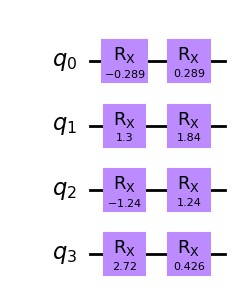

In [25]:
from qiskit.quantum_info import Statevector

# Ottengo il circuito ottimizzato
optimal_circuit = result.optimal_circuit.bind_parameters(result.optimal_parameters)
optimal_circuit.decompose().draw("mpl")

In [30]:
from qiskit.visualization.state_visualization import array_to_latex

# Ottengo lo state vector
state_vector = Statevector(optimal_circuit)
array_to_latex(state_vector, max_size=24)

<IPython.core.display.Latex object>

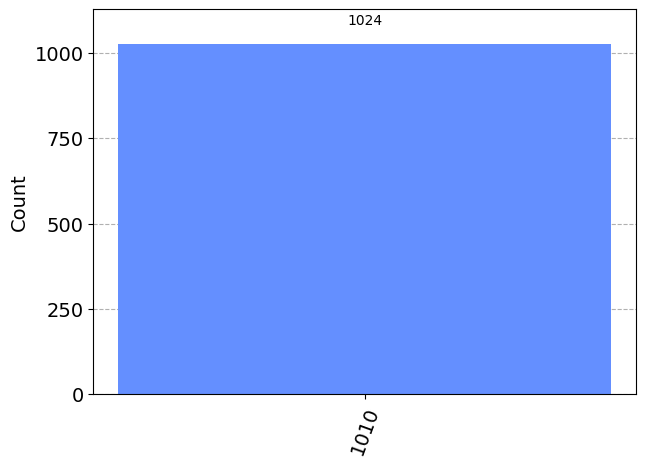

In [34]:
from qiskit import Aer, transpile
from qiskit.visualization import plot_histogram

#Misurazione
simulator = Aer.get_backend("aer_simulator")
qc = optimal_circuit.copy()
qc.measure_all()
qc_t = transpile(qc, simulator)
result = simulator.run(qc_t).result()
counts = result.get_counts()
plot_histogram(counts)

{(0, 1): Text(-0.4999999940375597, -0.5000000437113883, '1.0'),
 (0, 2): Text(0.0, 4.371138828673793e-08, '1.0'),
 (0, 3): Text(-0.500000168883119, 0.4999999562886117, '1.0'),
 (1, 2): Text(0.5000000059624403, -0.4999999125772234, '1.0'),
 (2, 3): Text(0.49999983111688096, 0.5000000874227766, '1.0')}

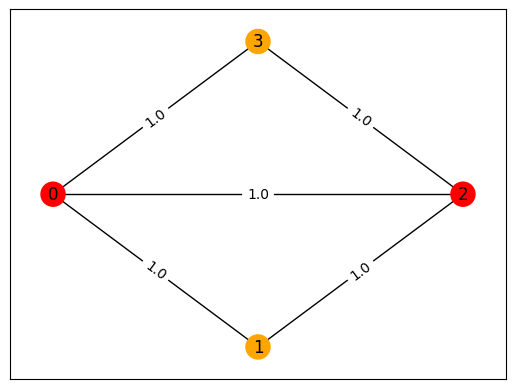

In [36]:
# Disegno i due sottografi

x = max_cut.sample_most_likely(state_vector)

colors = ["red" if x[i] == 0 else "orange" for i in range(n)]

layout = nx.shell_layout(G)
nx.draw_networkx(G, node_color=colors, pos=layout)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=edge_labels)